In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [36]:
torch.manual_seed(42)

In [37]:
device='cuda'

In [38]:
df = pd.read_csv('../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [39]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [40]:
def MSE(prediction_tensor, truth_tensor):
    return torch.sum(torch.pow(prediction_tensor-truth_tensor, 2))/truth_tensor.numel()

In [41]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [42]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('1min').mean()

In [43]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [44]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """
    target_length = seq_length // 3  # Target is 1/3 the size of the training sequence

    if len(data) < seq_length + target_length:
        raise ValueError("Data length must be at least seq_length + target_length.")

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length - target_length + 1):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length:i+seq_length+target_length]) # Target sequence

    return np.array(sequences), np.array(targets)


In [45]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece
# val_df1 = first_piece[int(n*0.4):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
# val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 90)
# val_seq1, val_labels1 = create_sequences(val_df1.values, 60)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device=device) # (batch, output_dim)
# val_seq_tensor1 = torch.FloatTensor(val_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
# val_label_tensor1 = torch.FloatTensor(val_labels1).to(device='cuda')  # (batch, output_dim)


In [46]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece
# val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
# val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 90)
# val_seq2, val_labels2 = create_sequences(val_df2.values, 90)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device=device) # (batch, output_dim)
# val_seq_tensor2 = torch.FloatTensor(val_seq2).to(device=device)  # (batch, seq_length, input_dim)
# val_label_tensor2 = torch.FloatTensor(val_labels2).to(device=device)  # (batch, output_dim)

In [47]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 = third_piece
# val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
# val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 90)
# val_seq3, val_labels3 = create_sequences(val_df3.values, 90)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device=device) # (batch, output_dim)
# val_seq_tensor3 = torch.FloatTensor(val_seq3).to(device=device)  # (batch, seq_length, input_dim)
# val_label_tensor3 = torch.FloatTensor(val_labels3).to(device=device)  # (batch, output_dim)

In [48]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 = fourth_piece[0:int(n*0.8)]
val_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 90)
val_seq4, val_labels4 = create_sequences(val_df4.values, 90)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4).to(device=device) # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4).to(device=device)  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4).to(device=device)  # (batch, output_dim)

In [49]:
len(train_labels1), len(train_seq1), len(train_df1.values)

(842, 842, 961)

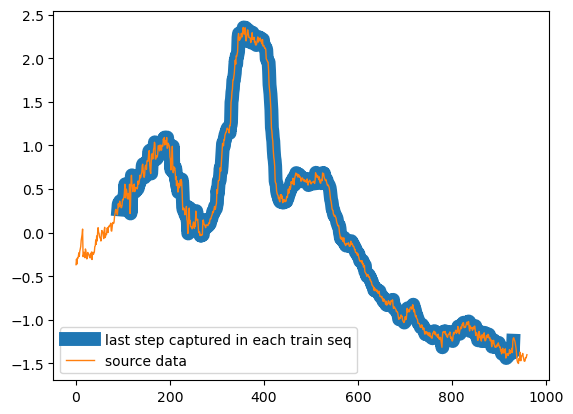

In [50]:
# first sequence - point 90 is plotted, then seconds sequence - 91, etc.
plt.plot(range(90,len(train_df1.values) + 1 - 30),train_seq1[:, -1, :], linewidth=10,  label='last step captured in each train seq')
plt.plot(train_df1.values, label='source data', linewidth=1)
plt.legend()

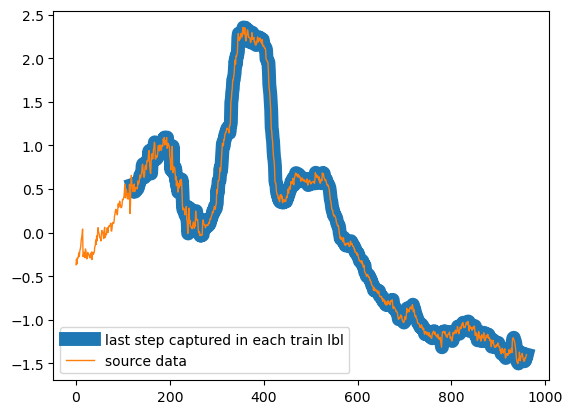

In [51]:
# the first last prediction is x_120, then x_121, etc.
# the last last prediction is 
plt.plot(range(120,len(train_df1.values)+1), train_labels1[:, -1, :], linewidth=10,  label='last step captured in each train lbl')
plt.plot(train_df1.values, label='source data', linewidth=1)
plt.legend()

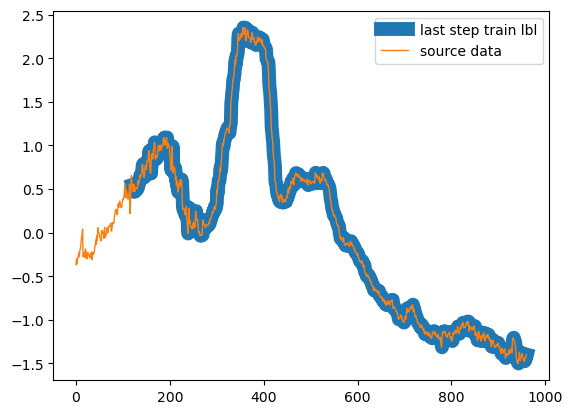

In [52]:
# the first last prediction is 120, then 121, etc.
plt.plot(range(120,len(train_df1.values)+1), train_labels1[:, -1, :], linewidth=10,  label='last step train lbl')
plt.plot(train_df1.values, label='source data', linewidth=1)
plt.legend()

In [53]:
train_df1.values[-1]

array([-1.40008858])

In [56]:
train_labels1[-1]

array([[-1.21054891],
       [-1.20564766],
       [-1.2279944 ],
       [-1.23962526],
       [-1.26229223],
       [-1.29659209],
       [-1.3359632 ],
       [-1.40365183],
       [-1.46118614],
       [-1.48382049],
       [-1.49261596],
       [-1.50047828],
       [-1.4457281 ],
       [-1.46217135],
       [-1.37048622],
       [-1.44297609],
       [-1.4695166 ],
       [-1.42573854],
       [-1.4100288 ],
       [-1.40664752],
       [-1.38510212],
       [-1.4216441 ],
       [-1.44380425],
       [-1.47140155],
       [-1.475346  ],
       [-1.46968523],
       [-1.43355643],
       [-1.43769485],
       [-1.42138024],
       [-1.40008858]])

In [19]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # print(out.shape)
        # out = self.do(out)
        out = self.fc(out[:, :30, :])  
        return out

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to(device)  # Use "cuda" if you have a GPU
criterion1 = nn.SmoothL1Loss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)

In [20]:
num_epochs = 800
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer1.zero_grad()
    # y_pred = model1(train_seq_tensor1).unsqueeze(-1)
    y_pred = model1(train_seq_tensor1)
    # print(y_pred.shape)
    # print(train_label_tensor1.shape)
    
    loss = criterion1(y_pred, train_label_tensor1)
    loss.backward()
    optimizer1.step()
    
    train_losses.append(loss.item())

    # Validation
    # model1.eval()
    # with torch.no_grad():
    #     y_val = model1(val_seq_tensor1)
    #     val_loss = criterion1(y_val, val_label_tensor1)
    #     val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}')

Epoch 0, Train Loss: 0.4792766571044922
Epoch 10, Train Loss: 0.47010767459869385
Epoch 20, Train Loss: 0.45178160071372986
Epoch 30, Train Loss: 0.39559370279312134
Epoch 40, Train Loss: 0.3245915174484253
Epoch 50, Train Loss: 0.30382034182548523
Epoch 60, Train Loss: 0.2980539798736572
Epoch 70, Train Loss: 0.2918323874473572
Epoch 80, Train Loss: 0.28733962774276733
Epoch 90, Train Loss: 0.28313571214675903
Epoch 100, Train Loss: 0.2792893052101135
Epoch 110, Train Loss: 0.27560314536094666
Epoch 120, Train Loss: 0.27228251099586487
Epoch 130, Train Loss: 0.2692299783229828
Epoch 140, Train Loss: 0.2658986449241638
Epoch 150, Train Loss: 0.2618016302585602
Epoch 160, Train Loss: 0.2569049298763275
Epoch 170, Train Loss: 0.25152820348739624
Epoch 180, Train Loss: 0.24645936489105225
Epoch 190, Train Loss: 0.24227525293827057
Epoch 200, Train Loss: 0.23858940601348877
Epoch 210, Train Loss: 0.23434874415397644
Epoch 220, Train Loss: 0.2286537140607834
Epoch 230, Train Loss: 0.2199221

In [21]:
num_epochs = 800
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer1.zero_grad()
    # y_pred = model1(train_seq_tensor1).unsqueeze(-1)
    y_pred = model1(train_seq_tensor2)
    # print(y_pred.shape)
    # print(train_label_tensor1.shape)
    
    loss = criterion1(y_pred, train_label_tensor2)
    loss.backward()
    optimizer1.step()
    
    train_losses.append(loss.item())

    # Validation
    # model1.eval()
    # with torch.no_grad():
    #     y_val = model1(val_seq_tensor1)
    #     val_loss = criterion1(y_val, val_label_tensor1)
    #     val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}')

Epoch 0, Train Loss: 0.3483458459377289
Epoch 10, Train Loss: 0.1389770805835724
Epoch 20, Train Loss: 0.11101796478033066
Epoch 30, Train Loss: 0.09815052151679993
Epoch 40, Train Loss: 0.09005479514598846
Epoch 50, Train Loss: 0.08511009812355042
Epoch 60, Train Loss: 0.08145586401224136
Epoch 70, Train Loss: 0.07856253534555435
Epoch 80, Train Loss: 0.07637609541416168
Epoch 90, Train Loss: 0.0745919793844223
Epoch 100, Train Loss: 0.07300674170255661
Epoch 110, Train Loss: 0.071506567299366
Epoch 120, Train Loss: 0.0701337605714798
Epoch 130, Train Loss: 0.06897231191396713
Epoch 140, Train Loss: 0.06781266629695892
Epoch 150, Train Loss: 0.06680843979120255
Epoch 160, Train Loss: 0.06602009385824203
Epoch 170, Train Loss: 0.06496298313140869
Epoch 180, Train Loss: 0.0639985203742981
Epoch 190, Train Loss: 0.06321347504854202
Epoch 200, Train Loss: 0.0627538338303566
Epoch 210, Train Loss: 0.061695683747529984
Epoch 220, Train Loss: 0.06103074550628662
Epoch 230, Train Loss: 0.0604

In [22]:
num_epochs = 800
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer1.zero_grad()
    # y_pred = model1(train_seq_tensor1).unsqueeze(-1)
    y_pred = model1(train_seq_tensor3)
    # print(y_pred.shape)
    # print(train_label_tensor1.shape)
    
    loss = criterion1(y_pred, train_label_tensor3)
    loss.backward()
    optimizer1.step()
    
    train_losses.append(loss.item())

    # Validation
    # model1.eval()
    # with torch.no_grad():
    #     y_val = model1(val_seq_tensor1)
    #     val_loss = criterion1(y_val, val_label_tensor1)
    #     val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}')

Epoch 0, Train Loss: 0.4699387550354004
Epoch 10, Train Loss: 0.24243681132793427
Epoch 20, Train Loss: 0.2176617830991745
Epoch 30, Train Loss: 0.20489296317100525
Epoch 40, Train Loss: 0.1937999129295349
Epoch 50, Train Loss: 0.18444882333278656
Epoch 60, Train Loss: 0.17663836479187012
Epoch 70, Train Loss: 0.17019888758659363
Epoch 80, Train Loss: 0.16462114453315735
Epoch 90, Train Loss: 0.1593807488679886
Epoch 100, Train Loss: 0.15448355674743652
Epoch 110, Train Loss: 0.14994153380393982
Epoch 120, Train Loss: 0.14950160682201385
Epoch 130, Train Loss: 0.1459226757287979
Epoch 140, Train Loss: 0.1421380341053009
Epoch 150, Train Loss: 0.13704213500022888
Epoch 160, Train Loss: 0.13364848494529724
Epoch 170, Train Loss: 0.13110625743865967
Epoch 180, Train Loss: 0.12872038781642914
Epoch 190, Train Loss: 0.12691730260849
Epoch 200, Train Loss: 0.13163688778877258
Epoch 210, Train Loss: 0.12710770964622498
Epoch 220, Train Loss: 0.12375644594430923
Epoch 230, Train Loss: 0.121445

In [23]:
model1.eval()
y_test_label = train_label_tensor1[20]
y_test_seq = train_seq_tensor1[20]
model1.eval()
with torch.no_grad():
    y_pred_test = model1(y_test_seq.unsqueeze(0))

# Plot test predictions
# plt.figure(figsize=(10, 5))
# plt.plot(train_label_tensor1[:, 1,:].cpu().numpy(), label="Actual")
# plt.plot(y_pred_test[:, 1, :].cpu().numpy(), label="Predicted")
# plt.legend()

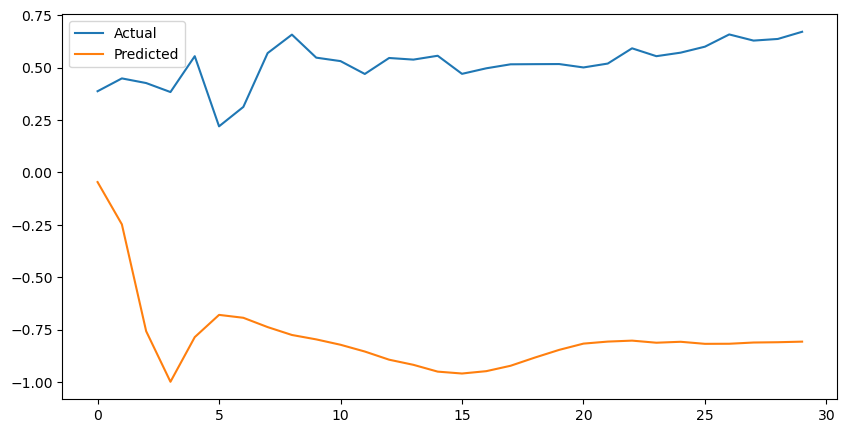

In [24]:
# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test_label.cpu().numpy(), label="Actual")
plt.plot(y_pred_test.cpu().numpy().squeeze(0), label="Predicted")
plt.legend()

In [25]:
MARE(y_pred_test, y_test_label).item()

2.567457437515259

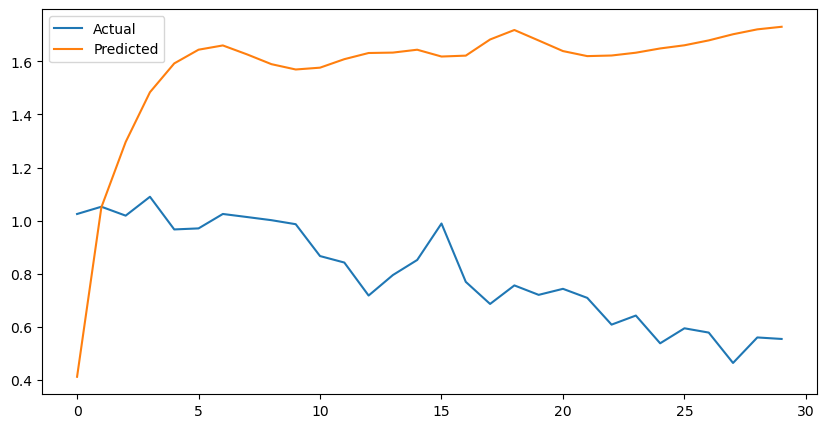

In [26]:
y_test_label = train_label_tensor1[100]
y_test_seq = train_seq_tensor1[100]
model1.eval()
with torch.no_grad():
    y_pred_test = model1(y_test_seq.unsqueeze(0))
plt.figure(figsize=(10, 5))
plt.plot(y_test_label.cpu().numpy(), label="Actual")
plt.plot(y_pred_test.cpu().numpy().squeeze(0), label="Predicted")
plt.legend()

In [27]:
MARE(y_pred_test, y_test_label).item()

1.1338002681732178

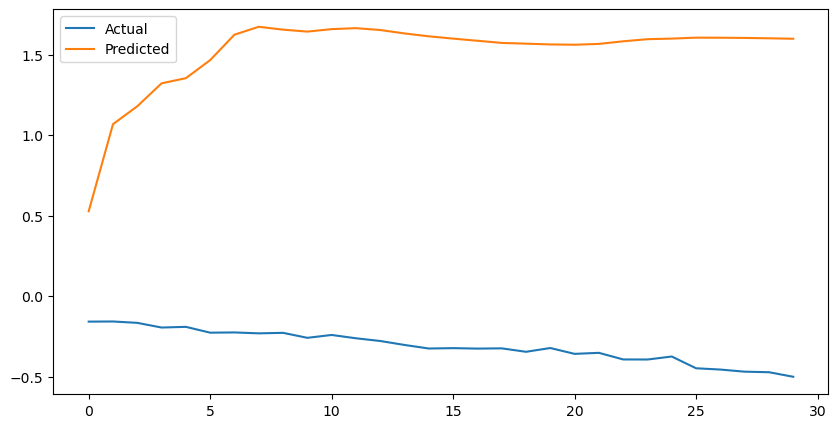

In [28]:
y_test_label = train_label_tensor1[500]
y_test_seq = train_seq_tensor1[500]
model1.eval()
with torch.no_grad():
    y_pred_test = model1(y_test_seq.unsqueeze(0))
plt.figure(figsize=(10, 5))
plt.plot(y_test_label.cpu().numpy(), label="Actual")
plt.plot(y_pred_test.cpu().numpy().squeeze(0), label="Predicted")
plt.legend()

In [29]:
len(train_seq_tensor1)

842

In [30]:
MARE(y_pred_test, y_test_label).item()

6.239614486694336

In [31]:
model1.eval()
error = 0
n_sequences = len(train_seq_tensor1)
for i in range(n_sequences):
    # ignore the last step since we don't have real data to compare with
    y_test_seq = train_seq_tensor1[i]
    y_test_label = train_label_tensor1[i]
    y_pred_test = model1(y_test_seq.unsqueeze(0))
    mare = MARE(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 4.3294967670798865


In [32]:
model1.eval()
error = 0
n_sequences = len(train_seq_tensor2)
for i in range(n_sequences):
    y_test_seq = train_seq_tensor2[i]
    y_test_label = train_label_tensor2[i]
    y_pred_test = model1(y_test_seq.unsqueeze(0))
    mare = MARE(y_pred_test, y_test_label).item()
    error += mare

avg_error = error/n_sequences
print(f'AVG error across sequences: {avg_error}')

AVG error across sequences: 6.169756535796948


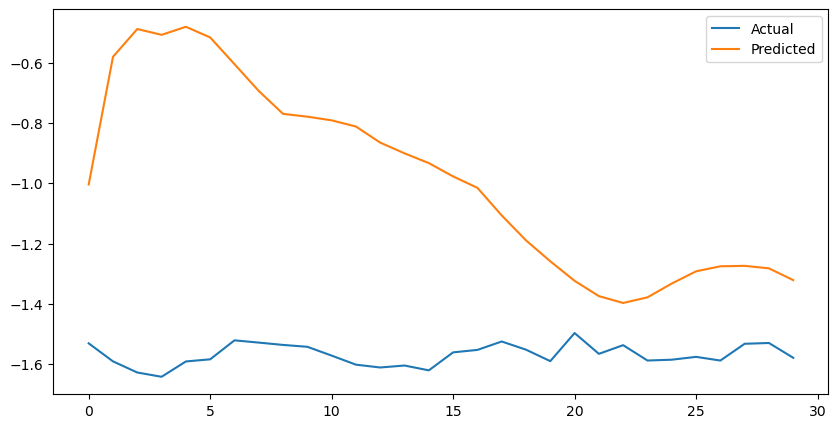

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_label.cpu().numpy(), label="Actual")
plt.plot(y_pred_test.cpu().detach().numpy().squeeze(0), label="Predicted")
plt.legend()

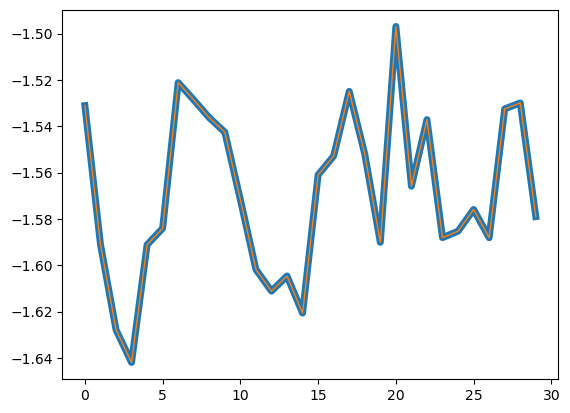

In [34]:
# confirm that predicting last 30
plt.plot(train_df2.values[-30:], linewidth=5)
plt.plot(y_test_label.cpu().numpy(), linewidth=1)